The goal is to determine the minimum number of frequency channels we can use in order to achieve the resolution we want. We will pull a lot from the DSA-10 design (https://arxiv.org/pdf/1906.08699.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 16})

### ~ Intrinsic values and limitations (DSA-10)

The DSA-10 makes use of an ADC that samples at 500 MHz. Furthermore, the DSA-10 uses a 4-tap, 4096 point FIR, which gives 2048 spectral channels.

In [2]:
ADC_rate = 500 # MHz
n_points = 4096
n_channels = 2048

Each channel holds 1B/ch (1 byte per channel) for a total of 2048B.

In [3]:
total_bytes = 2048 # B

We define a time between channels, $\Delta t$, as:

In [4]:
Δt = n_points/ADC_rate 
print('Δt =', Δt, 'μs (microseconds)')

Δt = 8.192 μs (microseconds)


As a result, we can then determine the data rate of the system, $R_{data}$:

In [5]:
R_data_bytes = total_bytes/Δt # MB/s
R_data_bits = R_data_bytes*8/1e3 # Gb/s
print('Data rate :', R_data_bytes, 'MB/s =', R_data_bits, 'Gb/s')

Data rate : 250.0 MB/s = 2.0 Gb/s


This data rate value is expected to be a general limitation on my system as well, so we have to work around this value.

### Frequency Channel Calculations

$\boxed{d\nu = \frac{1}{2dt}}$

In [12]:
def dv(dt):
#     dt [ms] --> dv [kHz]
    dv = 1/(2*dt)
    nchans = 250e3/dv / 2
    dr_bytes = (nchans)/(dt*1e3) # MBps
    dr_bits = dr_bytes*8 / 1e3 # Gbps
    print('Δν =', dv, 'kHz\nNumber of channels:', nchans, '\nData rate:', dr_bits, 'Gbps')

In [13]:
### DSA-10 model ###
dv(0.008192) # 8 μs

Δν = 61.03515625 kHz
Number of channels: 2048.0 
Data rate: 2.0 Gbps


Likely choice of time resolution: $\sim 0.1 ms$ (=1e-4 s)

In [18]:
dv(0.1) # 0.1 ms

Δν = 5.0 kHz
Number of channels: 25000.0 
Data rate: 2.0 Gbps


$t_{DM} = 4140\left(\frac{DM}{cm^{-3}\cdot pc}\right) \left(\frac{\nu}{MHz}\right)^{-2} s$

$\implies \Delta t_{DM} = 8280\left(\frac{DM}{cm^{-3}\cdot pc}\right) \left(\frac{\nu}{MHz}\right)^{-3} \Delta \nu$

$\implies \boxed{\Delta \nu = \frac{\Delta t_{DM}\cdot \nu^{-3}}{8280DM}}$

where DM is in $cm^{-3}\cdot pm$, $\nu$ is the center frequency in units of MHz, and $t_{DM}$ is in seconds.

In [68]:
def dv_DM(dt_DM, v_center, DM):
    # dt_DM [s], v_center [MHz], DM [cm^-3*pc]
    dv = (dt_DM*(v_center**3))/(8280*DM)
    dv_kHz = dv*1e3
    return dv_kHz # return in kHz

In [23]:
DM_SGR1935 = 332.72 # pc/cm**3

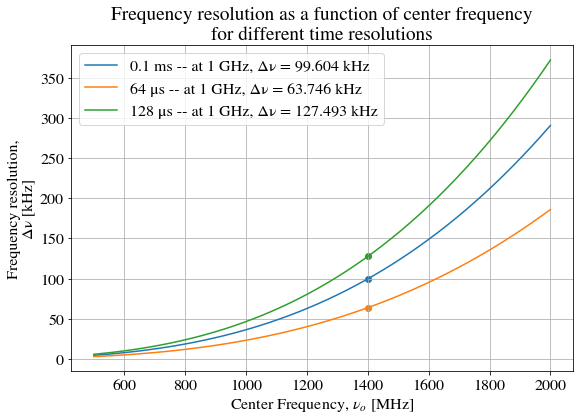

In [143]:
xs = np.linspace(500, 2000)
plt.figure(figsize=(9,6))
plt.title('Frequency resolution as a function of center frequency\nfor different time resolutions')
plt.plot(xs, dv_DM(1e-4, xs, DM_SGR1935), label='0.1 ms -- at 1 GHz, Δν = {0:.3f} kHz'.format(dv_DM(1e-4, 1400, DM_SGR1935)))
plt.plot(xs, dv_DM(64e-6, xs, DM_SGR1935), label='64 μs -- at 1 GHz, Δν = {0:.3f} kHz'.format(dv_DM(64e-6, 1400, DM_SGR1935)))
plt.plot(xs, dv_DM(128e-6, xs, DM_SGR1935), label='128 μs -- at 1 GHz, Δν = {0:.3f} kHz'.format(dv_DM(128e-6, 1400, DM_SGR1935)))
plt.scatter(1400, dv_DM(1e-4, 1400, DM_SGR1935))
plt.scatter(1400, dv_DM(64e-6, 1400, DM_SGR1935))
plt.scatter(1400, dv_DM(128e-6, 1400, DM_SGR1935))
plt.xlabel('Center Frequency, $ν_o$ [MHz]')
plt.ylabel('Frequency resolution,\nΔν [kHz]')
plt.grid()
plt.legend()
plt.show()

In [144]:
print('Number of frequency channels at center frequency of 1 GHz given time resolution:')
print('\n0.1 ms -- {0:.3f} channels -- Δν = {1:.3f} kHz'.format(250e3/dv_DM(1e-4, 1400, DM_SGR1935), dv_DM(1e-4, 1400, DM_SGR1935)))
print('64 μs -- {0:.3f} channels -- Δν = {1:.3f} kHz'.format(250e3/dv_DM(64e-6, 1400, DM_SGR1935), dv_DM(64e-6, 1400, DM_SGR1935)))
print('128 μs -- {0:.3f} channels -- Δν = {1:.3f} kHz'.format(250e3/dv_DM(128e-6, 1400, DM_SGR1935), dv_DM(128e-6, 1400, DM_SGR1935)))

Number of frequency channels at center frequency of 1 GHz given time resolution:

0.1 ms -- 2509.950 channels -- Δν = 99.604 kHz
64 μs -- 3921.798 channels -- Δν = 63.746 kHz
128 μs -- 1960.899 channels -- Δν = 127.493 kHz


In [145]:
def nchans(dt, v0, DM):
    return 250e3/dv_DM(dt, v0, DM_SGR1935)

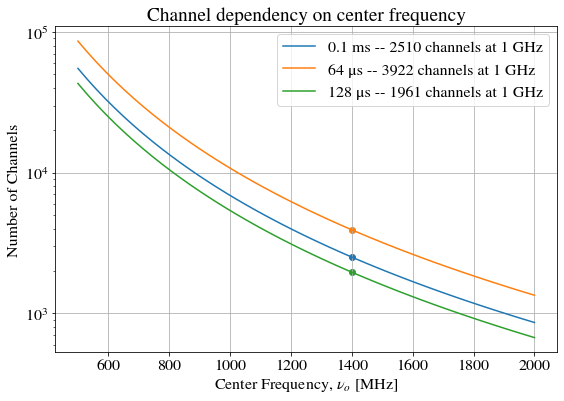

In [146]:
v0s = np.linspace(500, 2000)

plt.figure(figsize=(9,6))
plt.plot(v0s, nchans(1e-4, v0s, DM_SGR1935), label='0.1 ms -- {0:.0f} channels at 1 GHz'.format(nchans(1e-4, 1400, DM_SGR1935)))
plt.plot(v0s, nchans(64e-6, v0s, DM_SGR1935), label='64 μs -- {0:.0f} channels at 1 GHz'.format(nchans(64e-6, 1400, DM_SGR1935)))
plt.plot(v0s, nchans(128e-6, v0s, DM_SGR1935), label='128 μs -- {0:.0f} channels at 1 GHz'.format(nchans(128e-6, 1400, DM_SGR1935)))
plt.scatter(1400, nchans(1e-4, 1400, DM_SGR1935)) #, label='{0:.0f} channels'.format(nchans(1e-4, 1400, DM_SGR1935)))
plt.scatter(1400, nchans(64e-6, 1400, DM_SGR1935)) #, label='{0:.0f} channels'.format(nchans(64e-6, 1400, DM_SGR1935)))
plt.scatter(1400, nchans(128e-6, 1400, DM_SGR1935)) #, label='{0:.0f} channels'.format(nchans(128e-6, 1400, DM_SGR1935)))
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Center Frequency, $ν_o$ [MHz]')
plt.ylabel('Number of Channels')
plt.title('Channel dependency on center frequency')
plt.show()